In [71]:
# Enrico Borriello 
# Sept 1, 2023

#Fitting the scaling of the average control kernel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # interactive 3D plots
from scipy.optimize import curve_fit # non-linear fit
import time

In [2]:
data = pd.read_csv('CK_vs_entropy_data_scan.csv')
data_smallH = pd.read_csv('CK_vs_entropy_data_scan_231024.csv') # now with smallH permutation
data = data.drop('elapsed_time', axis=1)
data = data.drop('seed', axis=1)

# compute log2(r) and difference
data['log2(r)'] = np.log2(data['r'])
data['difference'] = data['ck_mean_size'] - data['log2(r)']
data_smallH['log2(r)'] = np.log2(data_smallH['r'])
data_smallH['difference'] = data_smallH['ck_mean_size'] - data_smallH['log2(r)']

In [3]:
def string_to_seconds(s):
    hours,minutes,seconds = [float(thing) for thing in s.split(':')]
    return 60*60*hours + 60*minutes + seconds

In [4]:
times = [ string_to_seconds(t) for t in data_smallH['elapsed_time'] ]

In [5]:
np.sum(times)/60/60

29.061428153055555

In [6]:
# average over network topologies with same n, r, and eta
averaged_data = pd.DataFrame(data.groupby(['n','r','eta'])[['ck_mean_size']].mean())
averaged_data = averaged_data.reset_index()
#averaged_data.head()

In [7]:
# average over network topologies with same n, r, and eta
averaged_data_smallH = pd.DataFrame(data_smallH.groupby(['n','r','eta'])[['ck_mean_size','h_max']].mean())
averaged_data_smallH = averaged_data_smallH.reset_index()
# Add log2(r) and difference
averaged_data_smallH['log2(r)'] = np.log2(averaged_data_smallH['r'])
averaged_data_smallH['difference'] = averaged_data_smallH['ck_mean_size'] - averaged_data_smallH['log2(r)']
#averaged_data.head()

In [4]:
#fig = px.scatter_3d(df, x='r', y='eta', z='difference')
#fig.update_layout(scene=dict(aspectmode='cube'))
#fig.update_traces(marker={'size': 3}) 
#fig.show()

### 2023/12/13 Normalize basin entropy and control kernel size

In [8]:
# compute "normalized" basin entropy and control kernel size
# (note that both of these end up dividing by log2(r))
data['max_eta'] = data['log2(r)']
data['fraction_of_max_eta'] = data['eta']/data['max_eta']
data['fractional_difference'] = data['difference']/data['log2(r)']

data_smallH['max_eta'] = data_smallH['log2(r)']
data_smallH['fraction_of_max_eta'] = data_smallH['eta']/data_smallH['max_eta']
data_smallH['fractional_difference'] = data_smallH['difference']/data_smallH['log2(r)']

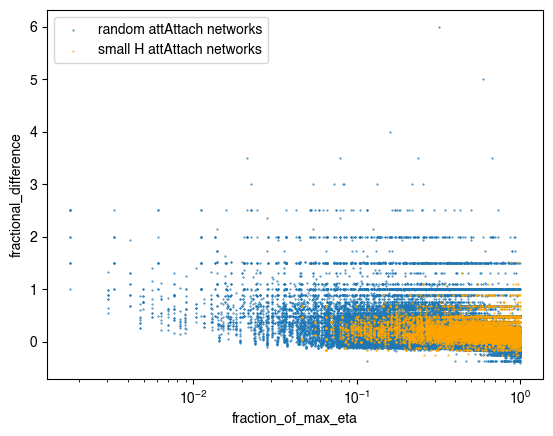

In [11]:
data.plot.scatter('fraction_of_max_eta','fractional_difference',s=0.2,
                  label='random attAttach networks')
data_smallH.plot.scatter('fraction_of_max_eta','fractional_difference',s=0.2,ax=plt.gca(),c='orange',
                        label='small H attAttach networks')
plt.xscale('log')

In [17]:
cc_df.columns

Index(['name', 'network_size', 'num_states', 'num_samples', 'num_attractors',
       'basin_entropy_NSB', 'std_basin_entropy_NSB', 'elapsed_time',
       'basin_entropy_naive', 'min_basin_count', 'mean control kernel size',
       'expected mean control kernel size',
       'difference from expected mean control kernel size',
       'max_basin_entropy', 'fraction_of_max_basin_entropy',
       'fractional difference from expected mean control kernel size'],
      dtype='object')

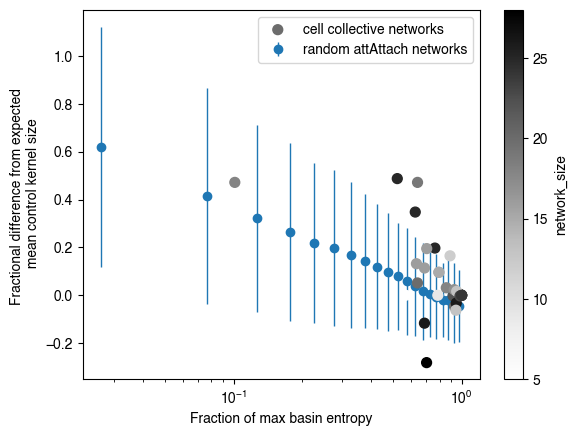

In [19]:
# bin and make errorbar plot
num_bins = 20 # 10
eta_cut,eta_bins = pd.cut(data['fraction_of_max_eta'],num_bins,retbins=True)
eta_cut_smallH = pd.cut(data_smallH['fraction_of_max_eta'],bins=eta_bins)
data['binned_fraction_of_max_eta'] = eta_cut
data_smallH['binned_fraction_of_max_eta'] = eta_cut_smallH

eta_bin_means = 0.5*(eta_bins[1:] + eta_bins[:-1])
means = data.groupby('binned_fraction_of_max_eta')['fractional_difference'].mean()
stds = data.groupby('binned_fraction_of_max_eta')['fractional_difference'].std()
plt.errorbar(eta_bin_means,means,yerr=stds,ls='',marker='o',lw=1,
             label='random attAttach networks')
if False:
    # also for smallH case
    means_smallH = data_smallH.groupby('binned_fraction_of_max_eta')['fractional_difference'].mean()
    stds_smallH = data_smallH.groupby('binned_fraction_of_max_eta')['fractional_difference'].std()
    plt.errorbar(eta_bin_means,means_smallH,yerr=stds_smallH,ls='',marker='o',color='darkorange',
                 label='small H attAttach networks',ms=3,lw=1,zorder=2)

# overlay cell collective networks
cc_df = pd.read_csv('231214_basin_entropy_and_ck_data_by_network.csv')
cc_df.plot.scatter('fraction_of_max_basin_entropy',
                   'fractional difference from expected mean control kernel size',
                   ax=plt.gca(),c='network_size',label='cell collective networks',
                   zorder=10,s=50)

plt.legend()
plt.xlabel('Fraction of max basin entropy')
plt.ylabel('Fractional difference from expected \n mean control kernel size');
plt.xscale('log')

### 2023/11/1 Restrict h_max

In [42]:
data_smallH.shape

(11950, 10)

In [88]:
data_smallH_restricted = data_smallH[data_smallH['h_max']<3]

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_33240/3405062249.py:24: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



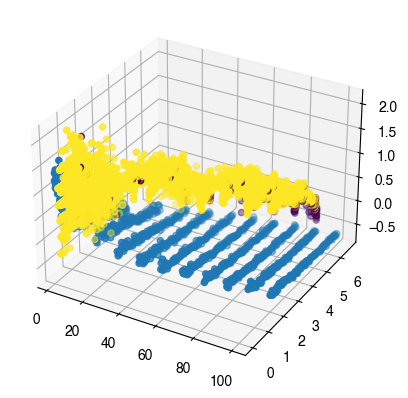

In [50]:
# plot both h-max case and random case

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# random case
ax.scatter(df['r'], df['eta'], df['difference'])

# h-max case
ax.scatter(data_smallH_restricted['r'], 
           data_smallH_restricted['eta'], 
           data_smallH_restricted['difference'], 
           c=data_smallH_restricted['h_max'])


#fig.update_layout(scene=dict(aspectmode='cube'))

#surface_trace = go.Surface(z=z, x=x, y=y, showscale=False, opacity=0.5, colorscale='gray')
#fig.update_traces(marker={'size': 4}) 

# Add the surface plot trace to the existing figure
#fig.add_trace(surface_trace)
fig.show()

In [84]:
data_n = data[data['n']==n]

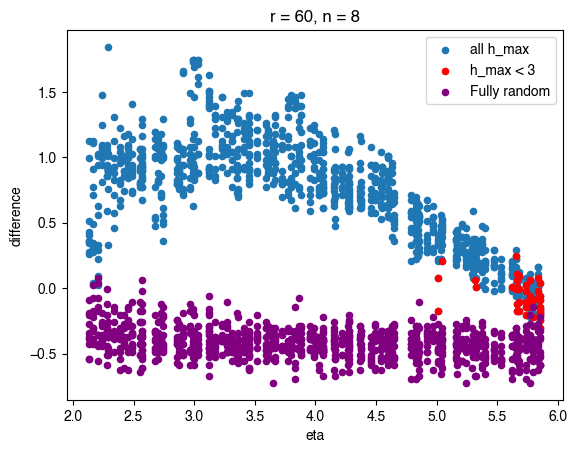

In [89]:
r = 60
data_smallH[data_smallH['r']==r].plot.scatter('eta','difference',label='all h_max')
ax = plt.gca()
data_smallH_restricted[data_smallH_restricted['r']==r].plot.scatter('eta','difference',ax=ax,
                                                                    color='red',label='h_max < 3')
data_n[data_n['r']==r].plot.scatter('eta','difference',ax=ax,color='purple',label='Fully random')
plt.legend()
plt.title('r = {}, n = {}'.format(r,n));

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_33240/545389029.py:3: RuntimeWarning:

divide by zero encountered in divide

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_33240/545389029.py:3: RuntimeWarning:

invalid value encountered in log2



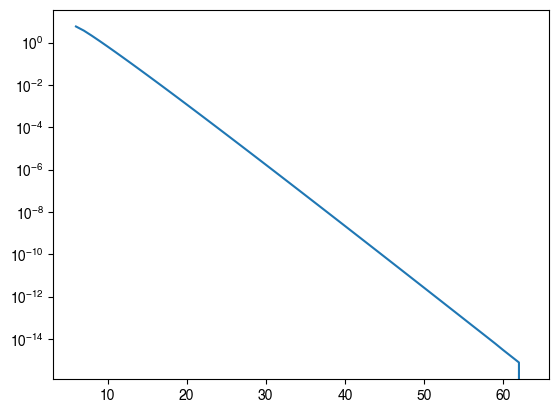

In [136]:
# How Does minimum entropy depend on N?
def min_basin_entropy(r,n):
    return (r-1)*n/2**n -(1-(r-1)/2**n)*np.log2((1-(r-1)/2**n))

r = 60
Nlist = np.arange(100)
plt.plot(Nlist,min_basin_entropy(r,Nlist))
plt.yscale('log')

In [123]:
def naive_ck_unstable(n,r,s):
    """
    Naive expectation for basin structure with s attractors with basin size 1 and
    all other attractors having equal basin sizes.
    
    n               : number of nodes
    r               : number of attractors
    s               : number of unstable attractors (basin size = 1)
    """
    mean_ck = 1./r * ( s*n + (r-s)*np.log2(r) )
    basin_entropy = s * n / (2**n) - (2**n - s)/(2**n) * np.log2((2**n - s)/(2**n)/(r-s))
    return basin_entropy, mean_ck

In [124]:
naive_ck_unstable(n,r,r-1)

(2.1345929358089606, 7.9651148432601415)

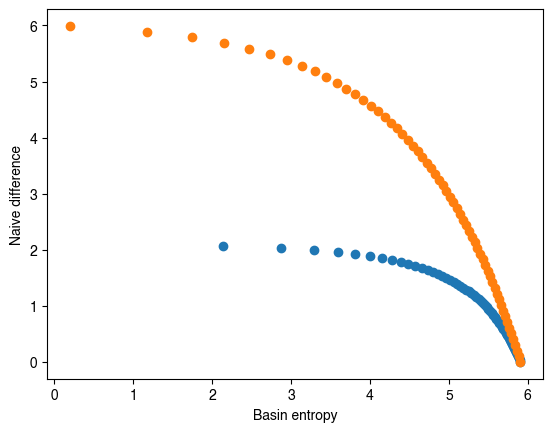

In [134]:
n = 8
n2 = 12

# plot with n
s_vals = range(r)
basin_entropies,mean_cks = np.transpose([ naive_ck_unstable(n,r,s) for s in s_vals ])
plt.plot(basin_entropies,mean_cks - np.log2(r),'o')

# plot with n2
s_vals = range(r)
basin_entropies,mean_cks = np.transpose([ naive_ck_unstable(n2,r,s) for s in s_vals ])
plt.plot(basin_entropies,mean_cks - np.log2(r),'o')

plt.xlabel('Basin entropy')
plt.ylabel('Naive difference');

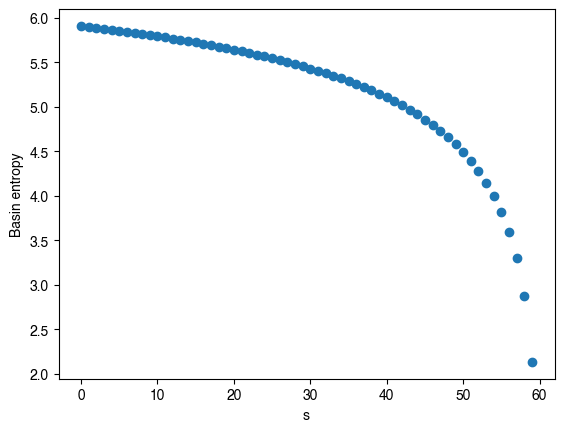

In [126]:
plt.plot(s_vals,basin_entropies,'o')
plt.xlabel('s')
plt.ylabel('Basin entropy');

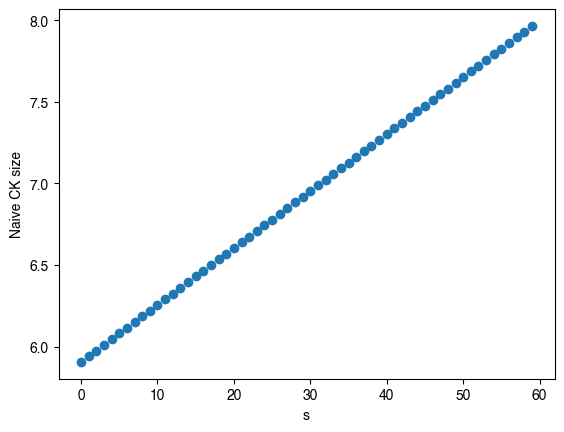

In [127]:
plt.plot(s_vals,mean_cks,'o')
plt.xlabel('s')
plt.ylabel('Naive CK size');

### Fit at fixed n

In [4]:
def func(r_eta, A, B, r0, eta0):
    # it needs to be function of a single variable
    # one way around it is to have r_eta = (r,eta)
    r, eta = np.array(r_eta)
    return A + B/((r+r0)*(eta+eta0)**2)

In [5]:
def func_exp(r_eta, C, D, r1, eta1):
    r, eta = np.array(r_eta)
    return C + D*np.exp(-r/abs(r1) - eta/abs(eta1))

In [6]:
def func_exp_mod(r_eta, C2, D2, r2, eta2,alpha):
    r, eta = np.array(r_eta)
    return C2 + D2*((r-1)**alpha)*np.exp(-r/abs(r2) - eta/abs(eta2))

**Model 1:** For fixed size of the network, $n$,

$$  \left< |CK| \right> - \log_2(r) = A + \frac{B}{(r+r_0)(\eta+\eta_0)^2}   $$

with $r =$ number of attractors and $\eta =$ basin entropy.

**Model 2:** For fixed size of the network, $n$,

$$  \left< |CK| \right> - \log_2(r) = C + D e^{-r/r_1 - \eta/\eta_1}   $$

with $r =$ number of attractors and $\eta =$ basin entropy.

**Model 3:** For fixed size of the network, $n$,

$$  \left< |CK| \right> - \log_2(r) = C_2 + D_2 (r-1)^{\alpha} e^{-r/r_2 - \eta/\eta_2}   $$

with $r =$ number of attractors and $\eta =$ basin entropy.

In [57]:
n = 8 #11 #11

df = averaged_data[averaged_data.n == n]
df[df.r==3]

df_smallH = averaged_data_smallH[averaged_data_smallH.n == n]

In [58]:
r_data = list(df.r)
eta_data = list(df.eta)
difference_data = list(df.difference)

In [48]:
# Fit (Note: It doesn't converge without a starting point.)

popt, pcov = curve_fit(func, (r_data, eta_data), difference_data, p0 = [1,1000,10,1],maxfev = 10000)
popt_exp, pcov_exp = curve_fit(func_exp, (r_data, eta_data), difference_data, p0 = [1,1,10,1],maxfev = 100000)
popt_exp_mod, pcov_exp_mod = curve_fit(func_exp_mod, (r_data, eta_data), 
                                       difference_data, p0 = [1,1,10,1,1],maxfev = 10000)
print("Model 1 parameters: {}".format(popt))
print("Model 2 parameters: {}".format(popt_exp))
print("Model 3 parameters: {}".format(popt_exp_mod))

Model 1 parameters: [ 7.36121341e-01 -6.53871921e+07  5.39447003e+00  5.01015769e+03]
Model 2 parameters: [   0.7016472    -0.38695004    9.46986109 -123.89363168]
Model 3 parameters: [ 7.04877583e-01 -2.31802294e-01  1.70452944e+00  7.23883713e+06
  2.28297348e+00]


### Plots

In [7]:
import plotly.graph_objs as go

In [8]:
r_range = np.linspace(0, 100, 101)
eta_range = np.linspace(0, 10,11)
x, y = np.meshgrid(r_range, eta_range)
z = func((x, y), *popt)
z_exp = func_exp((x,y), *popt_exp)

z_exp_mod = func_exp_mod((x,y), *popt_exp_mod)

NameError: name 'func' is not defined

In [9]:
# Hmax plot

fig = px.scatter_3d(df_smallH, x='r', y='eta', z='difference')
fig.update_layout(scene=dict(aspectmode='cube'))

surface_trace = go.Surface(z=z, x=x, y=y, showscale=False, opacity=0.5, colorscale='gray')
fig.update_traces(marker={'size': 4}) 

# Add the surface plot trace to the existing figure
#fig.add_trace(surface_trace)
fig.show()

NameError: name 'z' is not defined

In [62]:
# as a function of average h_max

fig = px.scatter_3d(df, x='h_max', y='r', z='difference')
fig.update_layout(scene=dict(aspectmode='cube'))

surface_trace = go.Surface(z=z, x=x, y=y, showscale=False, opacity=0.5, colorscale='gray')
fig.update_traces(marker={'size': 4}) 

# Add the surface plot trace to the existing figure
#fig.add_trace(surface_trace)
fig.show()

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_33240/1168161904.py:16: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



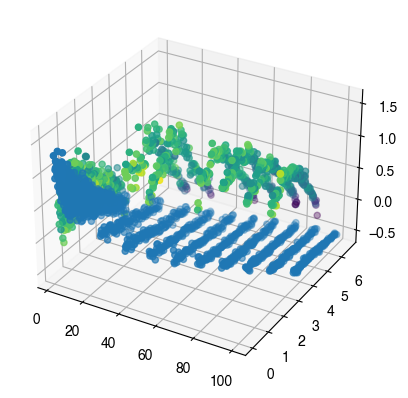

In [60]:
# h-max case

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df['r'], df['eta'], df['difference'])
ax.scatter(df_smallH['r'], df_smallH['eta'], df_smallH['difference'], c=df_smallH['h_max'])
#fig.update_layout(scene=dict(aspectmode='cube'))

# surface_trace = go.Surface(z=z, x=x, y=y, showscale=False, opacity=0.5, colorscale='gray')
# fig.update_traces(marker={'size': 4}) 

# Add the surface plot trace to the existing figure
#fig.add_trace(surface_trace)
fig.show()

In [81]:
# Model 1

fig = px.scatter_3d(df_smallH, x='r', y='eta', z='difference')
fig.update_layout(scene=dict(aspectmode='cube'))

surface_trace = go.Surface(z=z, x=x, y=y, showscale=False, opacity=0.5, colorscale='gray')
fig.update_traces(marker={'size': 4}) 

# Add the surface plot trace to the existing figure
fig.add_trace(surface_trace)
fig.show()

In [21]:
# Model 2

fig = px.scatter_3d(df, x='r', y='eta', z='difference')
fig.update_layout(scene=dict(aspectmode='cube'))

surface_trace = go.Surface(z=z_exp, x=x, y=y, showscale=False, opacity=0.5, colorscale='gray')
fig.update_traces(marker={'size': 4}) 

# Add the surface plot trace to the existing figure
fig.add_trace(surface_trace)
fig.show()

The data suggest that the fitting surface must have a peak at very low $r$. This is consistent with the fact that $\left< |CK| \right> - \log_2(r)$ must be zero at $r=1$. I've modiModify the exponential fitting function to account for that (model 3).

In [22]:
# Model 3

fig = px.scatter_3d(df, x='r', y='eta', z='difference')
fig.update_layout(scene=dict(aspectmode='cube'))

surface_trace = go.Surface(z=z_exp_mod, x=x, y=y, showscale=False, opacity=0.5, colorscale='gray')
fig.update_traces(marker={'size': 4}) 

# Add the surface plot trace to the existing figure
fig.add_trace(surface_trace)
fig.show()

In [24]:
def RMSD (list1, list2):
    chi2 = np.mean((list2-list1)**2)
    RMSD = np.sqrt(chi2)
    return RMSD

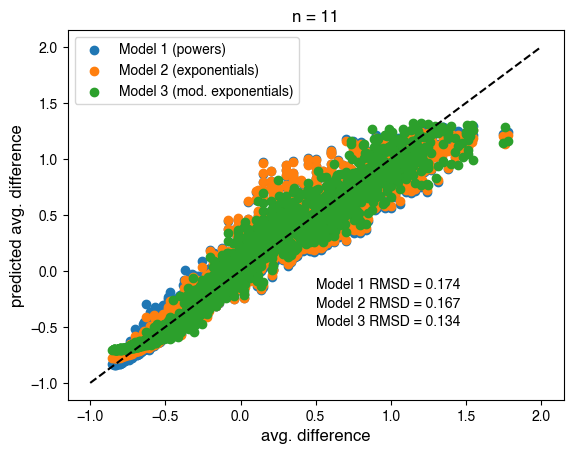

In [25]:
difference_pred = func((r_data, eta_data), *popt)
difference_pred_exp = func_exp((r_data, eta_data), *popt_exp)

difference_pred_exp_mod = func_exp_mod((r_data, eta_data), *popt_exp_mod)

plt.scatter(difference_data,difference_pred,label='Model 1 (powers)')
plt.scatter(difference_data,difference_pred_exp,label='Model 2 (exponentials)')

plt.scatter(difference_data,difference_pred_exp_mod,label='Model 3 (mod. exponentials)')

plt.plot([-1,2],[-1,2],'k--')
plt.xlabel('avg. difference',size=12)
plt.ylabel('predicted avg. difference',size=12)

rmsd = RMSD(difference_pred,difference_data)
rmsd_exp = RMSD(difference_pred_exp,difference_data)
rmsd_exp_mod = RMSD(difference_pred_exp_mod,difference_data)


plt.title('n = {}'.format(n))
plt.text(0.5,0.30,'Model 1 RMSD = {:.3f}'.format(rmsd),transform=plt.gca().transAxes)
plt.text(0.5,0.25,'Model 2 RMSD = {:.3f}'.format(rmsd_exp),transform=plt.gca().transAxes)

plt.text(0.5,0.20,'Model 3 RMSD = {:.3f}'.format(rmsd_exp_mod),transform=plt.gca().transAxes)

plt.legend()

plt.show()

### APPENDIX: Scaling with n

In [131]:
parameters,parameters_exp = [],[]
ns = [8,9,10,11]
for n in ns:
    df = averaged_data[averaged_data.n == n]
    r_data = list(df.r)
    eta_data = list(df.eta)
    difference_data = list(df.difference)
    popt, pcov = curve_fit(func, (r_data, eta_data), difference_data, p0 = [1,1000,10,1],maxfev = 10000)
    popt_exp, pcov_exp = curve_fit(func_exp, (r_data, eta_data), difference_data, p0 = [1,1,10,1],maxfev = 10000)
    parameters.append(popt)
    parameters_exp.append(popt_exp)
df_par = pd.DataFrame(parameters,columns = ['A','B','r0','eta0'],index=ns)
df_par_exp = pd.DataFrame(parameters_exp,columns = ['C','D','r1','eta1'],index=ns)

In [132]:
df_par

,A,B,r0,eta0
8,-0.637472,2128.729781,38.539974,5.567217
9,-0.800386,2559.231601,43.430372,5.348117
10,-0.944105,3705.839624,51.133412,5.716926
11,-1.005900,3654.545981,56.861661,5.185055


In [133]:
df_par_exp

,C,D,r1,eta1
8,-0.509570,1.597196,41.594787,3.020382
9,-0.648159,1.845806,48.531891,2.859493
10,-0.763073,1.986402,57.285866,2.946008
11,-0.817293,2.150304,64.005846,2.699195


In [134]:
# Assuming df is your DataFrame
average_df_par = df_par.mean()  # Calculate the average for each column
relative_change_df_par = (df_par - average_df_par) / average_df_par 

average_df_par_exp = df_par_exp.mean()  # Calculate the average for each column
relative_change_df_par_exp = (df_par_exp - average_df_par_exp) / average_df_par_exp

In [135]:
#relative_change_df_par['n'] = pd.DataFrame(range(8,12))
relative_change_df_par.reset_index(names=['n'],inplace=True)
relative_change_df_par_exp.reset_index(names=['n'],inplace=True)

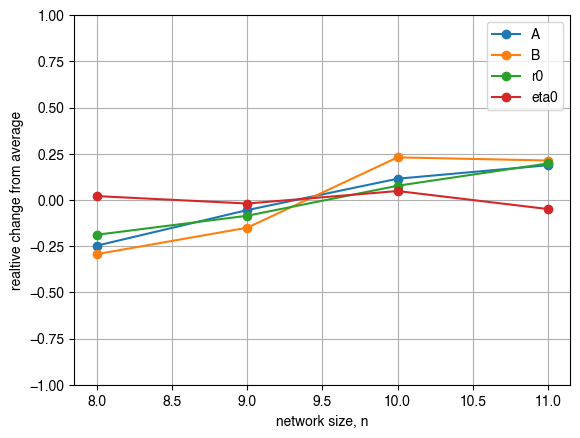

In [36]:
for column in ['A','B','r0','eta0']:
    plt.plot(relative_change_df_par['n'], relative_change_df_par[column], '-o',label=column)

plt.ylim(-1,1); plt.grid(True); plt.legend();
plt.xlabel('network size, n'); plt.ylabel('realtive change from average');

plt.show()

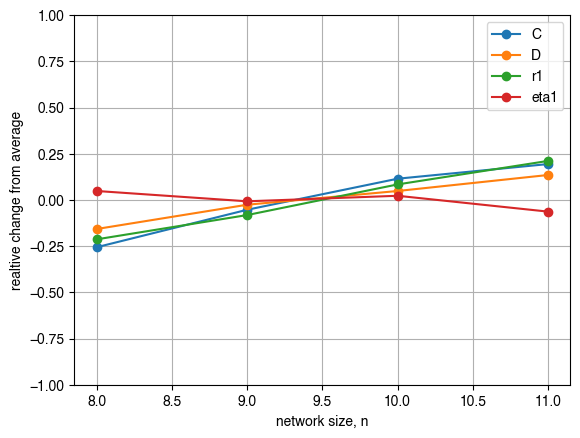

In [136]:
for column in ['C','D','r1','eta1']:
    plt.plot(relative_change_df_par_exp['n'], relative_change_df_par_exp[column], '-o',label=column)

plt.ylim(-1,1); plt.grid(True); plt.legend();
plt.xlabel('network size, n'); plt.ylabel('realtive change from average');

plt.show()

In [ ]:
# BCD 2023/9/14 
# What does small-r behavior look like as n increases?

In [21]:
# taken from entropy_and_basin_sizes.py

def min_basin_entropy(r,n):
    return (r-1)*n/2**n -(1-(r-1)/2**n)*np.log2((1-(r-1)/2**n))

def max_basin_entropy(r):
    """
    Note: This does not include a restriction due to having an
    integer number of states in each basin.  This could produce
    a bug in sampling near to the maximum entropy.
    """
    return np.log2(r)

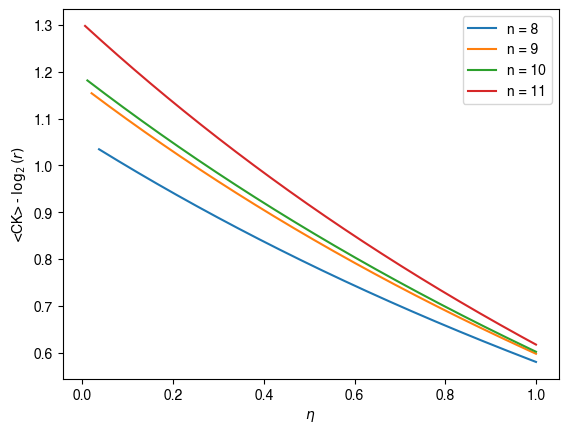

In [46]:
r = 2
for n in [8,9,10,11]:
    min_eta,max_eta = min_basin_entropy(r,n),max_basin_entropy(r)
    etas = np.linspace(min_eta,max_eta,1000)
    params = df_par.loc[n]
    A = params['A']
    B = params['B']
    r0 = params['r0']
    eta0 = params['eta0']
    predicted_diff = [ func((r,eta), A, B, r0, eta0) for eta in etas]
    plt.plot(etas,predicted_diff,label='n = {}'.format(n))
plt.xlabel('$\eta$')
plt.ylabel('<CK> - $\log_2(r)$')
plt.legend()

### APPENDIX: Fit with more parameters (alpha and beta)

In [20]:
# It doesn't work. Try this again after filling the gaps in the binning over r.

In [21]:
def func(r_eta, A, B, r0, eta0, alpha, beta):
    # it needs to be function of a single variable
    # one way around it is to have r_eta = (r,eta)
    r, eta = r_eta
    return A + B/( ((r+r0)**alpha) * ((eta+eta0)**beta)  )

In [22]:
r_data = list(df.r)
eta_data = list(df.eta)
difference_data = list(df.difference)

In [23]:
# Fit (Note: It doesn't converge without a starting point.)
popt, pcov = curve_fit(func, (r_data, eta_data), difference_data, p0 = [1,100,10,1,1,1])
print(popt)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.